# Age regression from brain MRI

Predicting the age of a patient from their brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

The objective for this notebook is to implement two supervised learning approaches for age regression from brain MRI. We use data from a total of 652 healthy subjects, that is split into different development sets and a hold-out test set on which you will evaluate your final prediction accuracy.

The two approaches are:
1. Use regression on the volumes of different tissue volumes which are obtained from a segmentation model we train. This strategy is done on Part A of this notebook.
2. Directly use the MRI scan as input to predict age. This method is done on Part B of this notebook.

### Getting started and familiarize ourselves with the data

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the total population of 652 subjects. The data will be split into different subsets to be used for different parts of this notebook. There is a set of 52 subjects to be used in part A to develop an image segmentation method (47 for training, 5 for validation). We then use 500 subjects for training and two-fold cross-validation of age regression approaches in part A and B. 

In [1]:
import numpy as np
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [1]:
! pip install SimpleITK==1.2.4 

     |████████████████████████████████| 42.5MB 75kB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Go to path
import os
if not os.path.exists('/content/drive/MyDrive/icl_mli_cw/'):
    os.makedirs('/content/drive/MyDrive/icl_mli_cw/')
    
%cd /content/drive/MyDrive/icl_mli_cw
%ls 

Mounted at /content/drive
/content/drive/MyDrive/icl_mli_cw
brainage-data.zip      brainage-testdata.zip.1  log.log
brainage-data.zip.1    brainage-testdata.zip.2  ML_Imaging_output/
brainage-testdata.zip  data/                    output/


### Downloading the data

In [ ]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip > log.log
! unzip brainage-data.zip > log.log

--2021-02-28 00:34:19--  https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 468654948 (447M) [application/zip]
Saving to: ‘brainage-data.zip’

brainage-data.zip   100%[===================>] 446.94M  35.4MB/s    in 14s     

2021-02-28 00:34:33 (32.1 MB/s) - ‘brainage-data.zip’ saved [468654948/468654948]



### Setting data directory

In [2]:
# data directory
data_dir = 'data/brain_age/'

Let's start by loading the meta data of the entire population, that is the data containing information about the subject IDs, their age, and gender.

In [3]:
# Read the meta data using pandas
import pandas as pd

meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head() # show the first five data entries

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look at some population statistics.

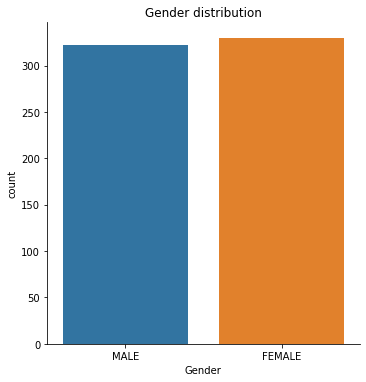

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


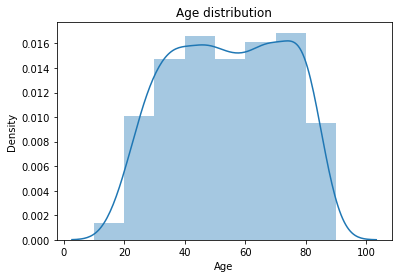

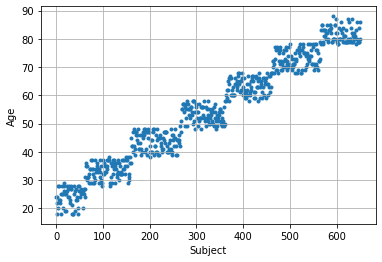

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

meta_data = meta_data_all

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Simple medical image viewer and import SimpleITK

In [4]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image


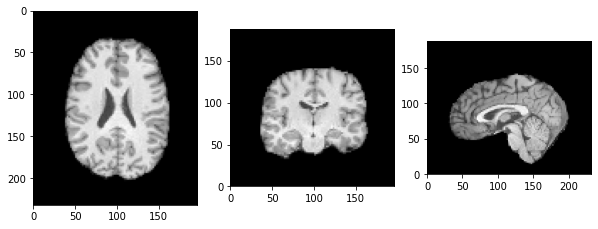

Brain mask


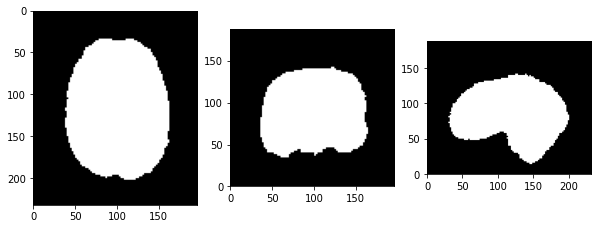

In [ ]:
# Subject with index 0
ID = meta_data['subject_id'][0]
age = meta_data['age'][0]

# Image
image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
img = sitk.ReadImage(image_filename)

# Mask
mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
msk = sitk.ReadImage(mask_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image')
display_image(img, window=400, level=200)
print('Brain mask')
display_image(msk)

## Part A: Age prediction using brain tissue segmentation and volume features

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain tissues include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented which will be trained using a total of 52 subjects (47 for training, 5 for validation). The segmentation method is then applied to the remaining 600 brain scans which will be used to train and test the age regression. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

### Brain tissue segmentation

We implement a CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task we use a subset of 52 subjects which are split into 47 images for training and 5 for validation. 

Once our model is trained, we apply it to the 500 subjects later used for training the age regressor. We provide reference segmentations in a subfolder `segs_refs` for all subjects. We calculate Dice similarity coefficients per tissue when comparing your predicted segmentations to the reference segmentations.

In [5]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#### Data Helpers

In [6]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]


Check that the GPU is up and running

In [7]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: GeForce GTX TITAN X


#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.


In [19]:
rnd_seed = 42 #fixed random seed

img_size = [96, 96, 96]
img_spacing = [2, 2, 2]

num_epochs = 400 # was 50
learning_rate = 0.0005
batch_size = 5
val_interval = 80

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading and pre-processing of training and validation data

In [ ]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_segmentation_train.csv')
ids_seg_train = list(meta_data_seg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_segmentation_val.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

In [ ]:
# LOAD TRAINING DATA
dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# LOAD VALIDATION DATA
dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


In [ ]:
batch = next(iter(dataloader_train))
img = batch['img']
seg = batch['seg']
print(img.shape)
print(seg.shape)

torch.Size([5, 1, 96, 96, 96])
torch.Size([5, 1, 96, 96, 96])


#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: sub-CC221040_T1w_unbiased.nii.gz


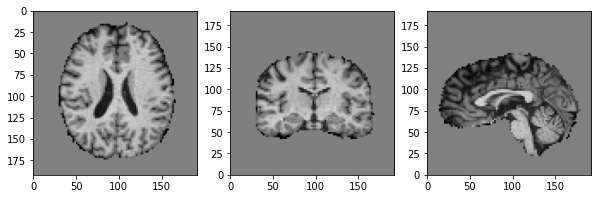

Segmentation


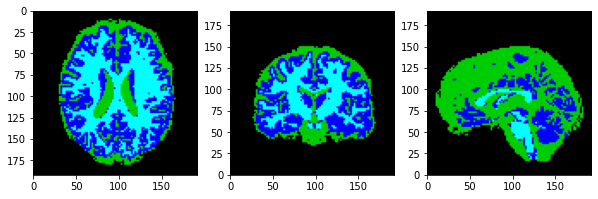

Mask


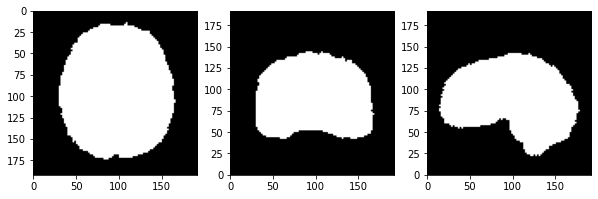

In [ ]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### The Model

In [8]:
class SimpleNet3D(nn.Module):

    def __init__(self, num_classes):
        super(SimpleNet3D, self).__init__()

        ###########################################################
        # Layers for a U-Net structure
        ###########################################################
        # state size: 1 x 64 x 64 x 64
        self.layers_1 = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm3d(8),
        )
        # state size: 8 x 64 x 64 x 64
        self.maxpool_1 = nn.MaxPool3d(2)
        # state size: 8 x 32 x 32 x 32
        self.layers_2 = nn.Sequential(
            nn.Conv3d(8, 16, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm3d(16),
        )

        # state_size: 16 x 32 x 32 x 32
        self.uplayers_1 = nn.Sequential(
            nn.ConvTranspose3d(16, 8, kernel_size=2, stride=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm3d(8)
        )
        # We add a skip connection, doubling the channels from 8 to 16
        # state_size: 16 x 64 x 64 x 64
        self.layers_3 = nn.Sequential(
            nn.Conv3d(8*2, 32, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm3d(32),
        # state_size: 32 x 64 x 64 x 64
            nn.Conv3d(32, num_classes, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm3d(num_classes),
        # state_size: num_classes x 64 x 64 x 64
        )


    def forward(self, x):

        l1 = self.layers_1(x)
        x = self.maxpool_1(l1)
        x = self.layers_2(x)
        x = self.uplayers_1(x)

        # Skip connection
        x = torch.cat([l1,x], dim=1)
        x = self.layers_3(x)
        
        return x # cross-entropy loss expects raw logits and applies softmax


model = SimpleNet3D(num_classes=4).to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
with torch.no_grad():
    img = img.to(device)
    out = model(img[0].unsqueeze(0))
    print('out shape:',out.shape)
    prd = torch.argmax(out, dim=1)

    prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
    display_image(sitk.LabelToRGB(prediction))

Total number of parameters is: 22180


NameError: name 'img' is not defined

#### TRAINING

START TRAINING...
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 0.868135
torch.Size([1, 96, 96, 96])


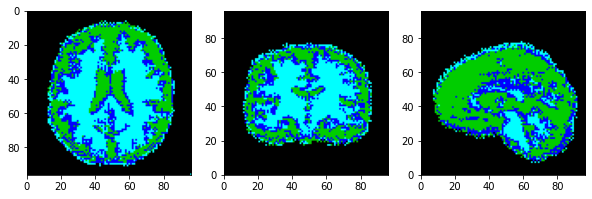

--------------------------------------------------
+ TRAINING 	Epoch: 10 	Loss: 0.696564
+ TRAINING 	Epoch: 20 	Loss: 0.622448
+ TRAINING 	Epoch: 30 	Loss: 0.526993
+ TRAINING 	Epoch: 40 	Loss: 0.499358
+ TRAINING 	Epoch: 50 	Loss: 0.450827
+ TRAINING 	Epoch: 60 	Loss: 0.398478
+ TRAINING 	Epoch: 70 	Loss: 0.377373
+ TRAINING 	Epoch: 80 	Loss: 0.348195
--------------------------------------------------
+ VALIDATE 	Epoch: 80 	Loss: 0.361138
torch.Size([1, 96, 96, 96])


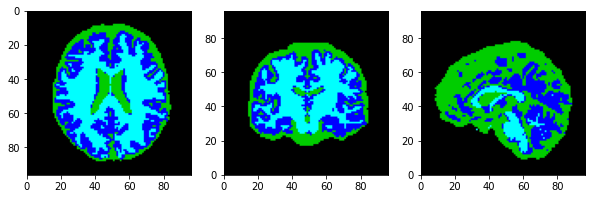

--------------------------------------------------
+ TRAINING 	Epoch: 90 	Loss: 0.340887
+ TRAINING 	Epoch: 100 	Loss: 0.318693
+ TRAINING 	Epoch: 110 	Loss: 0.282264
+ TRAINING 	Epoch: 120 	Loss: 0.265469
+ TRAINING 	Epoch: 130 	Loss: 0.269938
+ TRAINING 	Epoch: 140 	Loss: 0.266633
+ TRAINING 	Epoch: 150 	Loss: 0.233561
+ TRAINING 	Epoch: 160 	Loss: 0.237721
--------------------------------------------------
+ VALIDATE 	Epoch: 160 	Loss: 0.215870
torch.Size([1, 96, 96, 96])


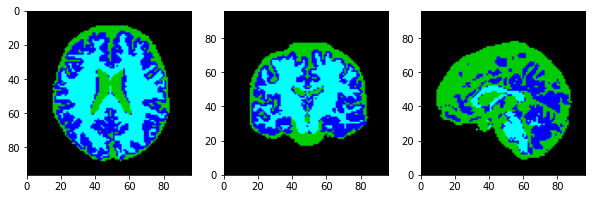

--------------------------------------------------
+ TRAINING 	Epoch: 170 	Loss: 0.202482
+ TRAINING 	Epoch: 180 	Loss: 0.201790
+ TRAINING 	Epoch: 190 	Loss: 0.198003
+ TRAINING 	Epoch: 200 	Loss: 0.182382
+ TRAINING 	Epoch: 210 	Loss: 0.163898
+ TRAINING 	Epoch: 220 	Loss: 0.161583
+ TRAINING 	Epoch: 230 	Loss: 0.156719
+ TRAINING 	Epoch: 240 	Loss: 0.153061
--------------------------------------------------
+ VALIDATE 	Epoch: 240 	Loss: 0.150330
torch.Size([1, 96, 96, 96])


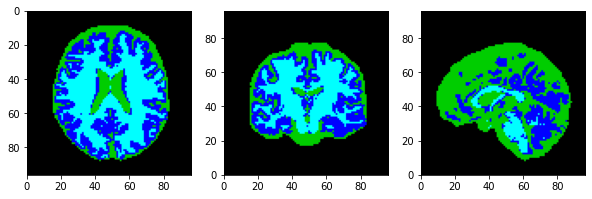

--------------------------------------------------
+ TRAINING 	Epoch: 250 	Loss: 0.151042
+ TRAINING 	Epoch: 260 	Loss: 0.141603
+ TRAINING 	Epoch: 270 	Loss: 0.132562
+ TRAINING 	Epoch: 280 	Loss: 0.129688
+ TRAINING 	Epoch: 290 	Loss: 0.166645
+ TRAINING 	Epoch: 300 	Loss: 0.124007
+ TRAINING 	Epoch: 310 	Loss: 0.124607
+ TRAINING 	Epoch: 320 	Loss: 0.121453
--------------------------------------------------
+ VALIDATE 	Epoch: 320 	Loss: 0.116939
torch.Size([1, 96, 96, 96])


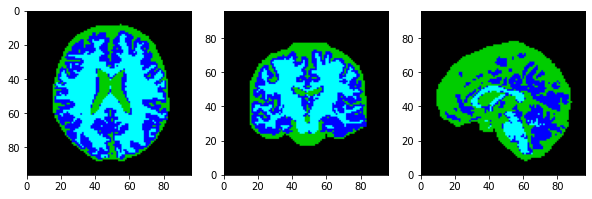

--------------------------------------------------
+ TRAINING 	Epoch: 330 	Loss: 0.127859
+ TRAINING 	Epoch: 340 	Loss: 0.107632
+ TRAINING 	Epoch: 350 	Loss: 0.114520
+ TRAINING 	Epoch: 360 	Loss: 0.103524
+ TRAINING 	Epoch: 370 	Loss: 0.104814
+ TRAINING 	Epoch: 380 	Loss: 0.099694
+ TRAINING 	Epoch: 390 	Loss: 0.118711
+ TRAINING 	Epoch: 400 	Loss: 0.098394
--------------------------------------------------
+ VALIDATE 	Epoch: 400 	Loss: 0.095644
torch.Size([1, 96, 96, 96])


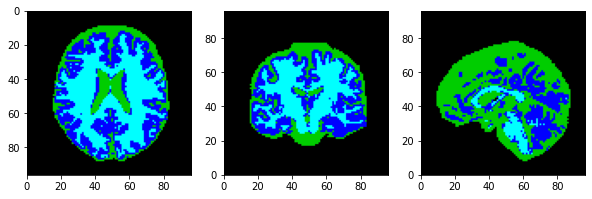

--------------------------------------------------

Finished TRAINING.


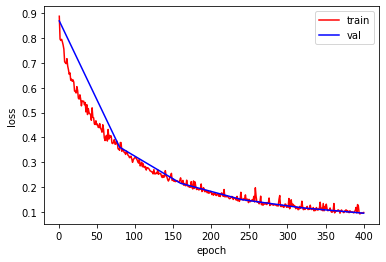

In [ ]:
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

model = SimpleNet3D(num_classes=num_classes).to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []
epoch_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        loss = F.cross_entropy(prd, seg.squeeze(1))
        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    if epoch % 10 == 0: # Print training info every 10 epochs
        print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                loss_val += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
                sum_pts += np.prod(img_size)
                
        prd = torch.argmax(prd, dim=1)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        

        loss_val /= sum_pts

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
        print(prd.shape)
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Loading and pre-processing of testing data

Now that we have trained a model, the next cells are about applying that model to the 500 subjects that are used for training the age regressor. 

In [ ]:
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_seg_test = list(meta_data_reg_train['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 500/500 [12:07<00:00,  1.46s/it]


#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: sub-CC520745_T1w_unbiased.nii.gz


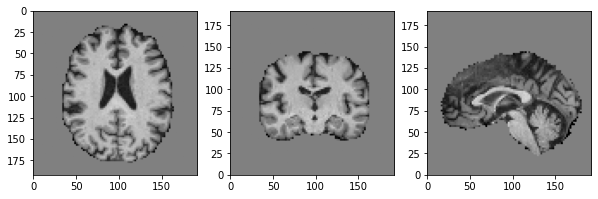

Segmentation


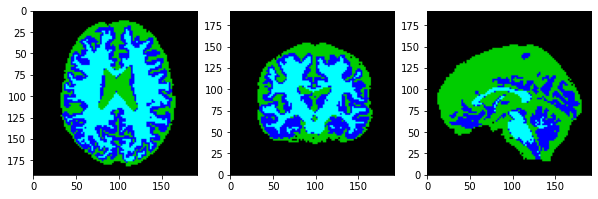

Mask


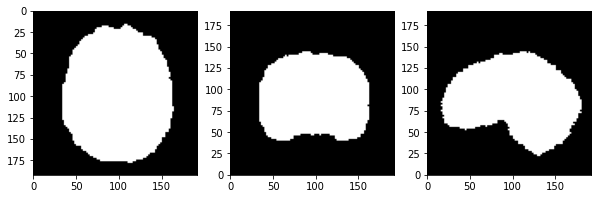

In [ ]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

Below is an implementation of a full testing procedure that saves the segmentations in an output folder. 

In [8]:
def metrics(pred, segm):
    '''
    Function that calculates the dice score and volume similarity for each class
    '''
    classes = segm.unique()
    # Dice Similarity Coefficients
    dices = torch.zeros_like(classes, dtype=torch.float)
    # Volume similarity
    volumes = torch.zeros_like(classes, dtype=torch.float)
    #print("classes:",classes)
    for c in classes:
        true_class_c = (segm==c)
        TP = (1.0*(pred[true_class_c]==c)).sum()
        FP = (1.0*(pred[~true_class_c]==c)).sum()
        TN = (1.0*(pred[~true_class_c]!=c)).sum()
        FN = (1.0*(pred[true_class_c]!=c)).sum()
        dice = 2*TP / (2*TP + FP + FN)
        dices[c] = dice

        volume = 1 - torch.abs(FN-FP) / (2*TP + FP + FN)
        volumes[c] = volume

    return dices, volumes

START TESTING...
+ TESTING 	Loss: 0.103870
+ dice losses: tensor([0.9912, 0.8239, 0.9132, 0.9388], device='cuda:0')
+ volume similarity: tensor([0.9965, 0.9332, 0.9705, 0.9713], device='cuda:0')


Reference segmentation


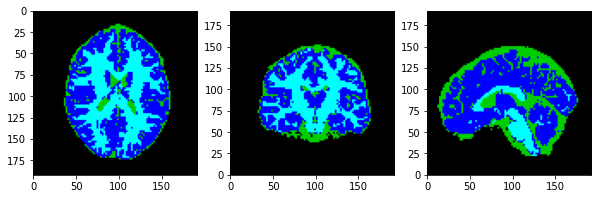

Predicted segmentation


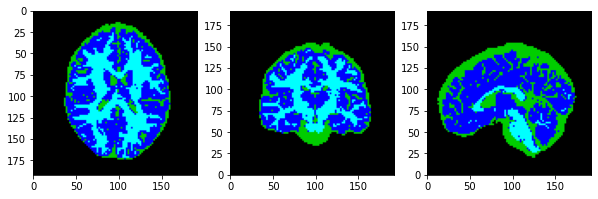


Finished TESTING.


In [ ]:
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = SimpleNet3D(num_classes=num_classes)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
        

print('START TESTING...')
dices = torch.zeros(size=[len(dataloader_test),4], dtype=torch.float,device=device)
volumes = torch.zeros(size=[len(dataloader_test),4], dtype=torch.float,device=device)
loss_test = 0
sum_pts = 0
idx_test = 0
with torch.no_grad():
    for data_sample in dataloader_test:

        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        loss_test += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
        sum_pts += np.prod(img_size)
        
        prd = torch.argmax(prd, dim=1)

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        
        # added code here to calculate Dice scores
        seg = seg.squeeze(1) # To get it into shape 1x64x64x64, like prd.
        d, v = metrics(prd, seg)
        dices[idx_test] = d
        volumes[idx_test] = v

        idx_test += 1
            
loss_test /= sum_pts

print('+ TESTING \tLoss: {:.6f}'.format(loss_test))
print('+ dice losses:',dices.mean(dim=0))
print('+ volume similarity:',volumes.mean(dim=0))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')


 Boxplots of metrics


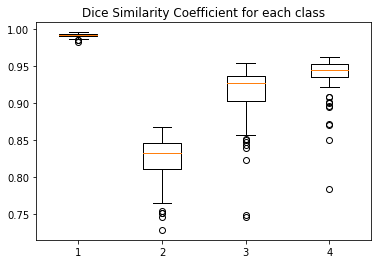

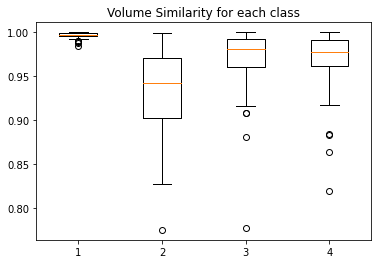

In [ ]:
print("\n Boxplots of metrics")
plt.boxplot(dices.cpu().numpy())
plt.title('Dice Similarity Coefficient for each class')
plt.show()

plt.boxplot(volumes.cpu().numpy())
plt.title('Volume Similarity for each class')
plt.show()


### Feature calculation

We start by calculating the three absolute tissue volumes for each subject. We plot the volumes against the subjects' ages. Taking the absolute volumes of tissues as features is not as predictive as using relative volumes. 

In [9]:
## CALCULATE ABSOLUTE TISSUE VOLUMES

import os

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
seg_dir = './output/pred/'
data_dir = '/vol/bitbucket/yc7620/90_data/21_brainage_data/data/brain_age/'


def get_vols_from_images(seg_dir, data_dir, meta_data):
    '''Function to load images and compute volumes per class.
    
    Returns volumes and age for each sample.'''

    meta_data_reg_train = pd.read_csv(data_dir + meta_data)
    ids_reg_train = list(meta_data_reg_train['subject_id'])
    files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]

    # THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
    vols = np.zeros((3,len(files_reg_seg_train)))

    for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):

        seg_filename = files_reg_seg_train[idx]
        if os.path.exists(seg_filename):
            seg = sitk.ReadImage(seg_filename)
            vols[:,idx] = np.bincount(sitk.GetArrayFromImage(seg).flatten())[1:] 
        else:
            print('no path')
    return vols, meta_data_reg_train['age']


seg_dir = './output/pred/'
meta_data = 'meta/meta_data_regression_train.csv'
vols, age = get_vols_from_images(seg_dir, data_dir, meta_data)
    

Calculating Features: 100%|██████████| 500/500 [00:11<00:00, 42.60it/s]


Plot features versus age.

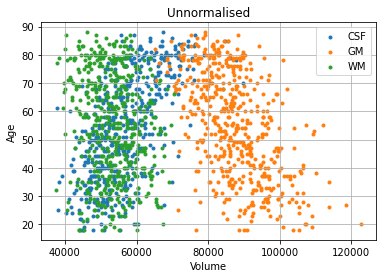

In [ ]:
plt.scatter(vols[0,:],age, marker='.')
plt.scatter(vols[1,:],age, marker='.')
plt.scatter(vols[2,:],age, marker='.')
plt.grid()
plt.title('Unnormalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

In [10]:
## CALCULATE RELATIVE TISSUE VOLUMES
vols_normalised = vols / vols.sum(axis=0)

Plot normalised features versus age.

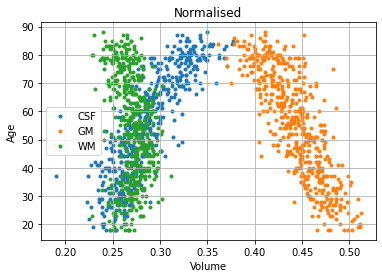

In [ ]:
plt.scatter(vols_normalised[0,:],age, marker='.')
plt.scatter(vols_normalised[1,:],age, marker='.')
plt.scatter(vols_normalised[2,:],age, marker='.')
plt.grid()
plt.title('Normalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

Final data for age regression

In [16]:
X = vols_normalised.T
y = age.values.reshape(-1,1)

print(X.shape)
print(y.shape)

(500, 3)
(500, 1)


### Age regression and cross-validation

We apply three different regression algorithms on the segmentations we obtained above using their relative volumes as regressors.


In [17]:
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_predict, train_test_split, GridSearchCV, ParameterGrid, cross_val_score
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, r2_score

# Do 2-fold cross-validation for prediction on each selected model
CV_SPLIT = 2

# Model 1: KNN 
y_pred_knn = cross_val_predict(KNeighborsRegressor(n_neighbors=5), X, y, cv=CV_SPLIT)
knn_MAE = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y, 
                            scoring = 'neg_mean_absolute_error', cv=CV_SPLIT).mean()
knn_r2 = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y, 
                            scoring = 'r2', cv=CV_SPLIT).mean()

# Model 2: SVM regressor
svr = GridSearchCV(SVR(), {'kernel':['poly', 'rbf'], 'degree':[3,4,5,6,7]},
                    scoring = 'neg_mean_absolute_error', 
                   cv=4). fit(X,y.reshape(500))

svr_MAE = cross_val_score(svr.best_estimator_, X, y.reshape(500), 
                          scoring = 'neg_mean_absolute_error', 
                          cv=CV_SPLIT).mean()
svr_r2 = cross_val_score(svr.best_estimator_, X, y.reshape(500), 
                          scoring = 'r2', 
                          cv=CV_SPLIT).mean()

y_pred_svr = cross_val_predict(svr.best_estimator_, X, y.reshape(500), cv=CV_SPLIT)

# Model 3: Lasso least-squares
lasso = GridSearchCV(Lasso(), 
                     {'alpha':[0.005,0.01,.1,.5,1.], 'normalize':[True,False]},
                     scoring = 'neg_mean_absolute_error',cv=4).fit(X,y)

lasso_MAE = cross_val_score(lasso.best_estimator_, X, y, 
                          scoring = 'neg_mean_absolute_error', 
                          cv=CV_SPLIT).mean() 
lasso_r2 = cross_val_score(lasso.best_estimator_, X, y, 
                          scoring = 'r2', 
                          cv=CV_SPLIT).mean()

y_pred_lasso = cross_val_predict(lasso.best_estimator_, X, y.reshape(500), cv=CV_SPLIT)

In [13]:
print('Obtained estimators via grid search')
print(svr.best_estimator_)
print(lasso.best_estimator_)

Obtained estimators via grid search
SVR(degree=4, kernel='poly')
Lasso(alpha=0.005, normalize=True)


Error calculation and plotting

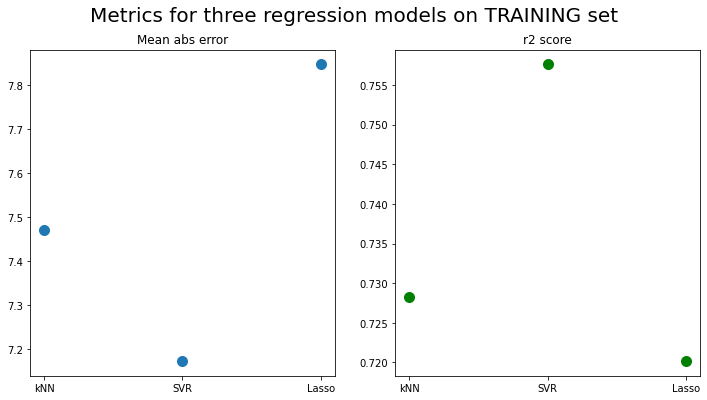

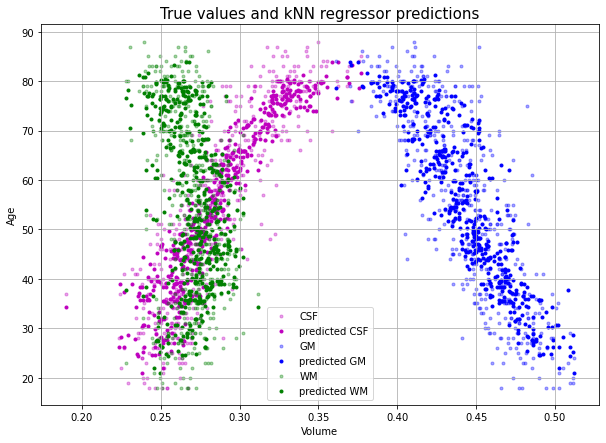

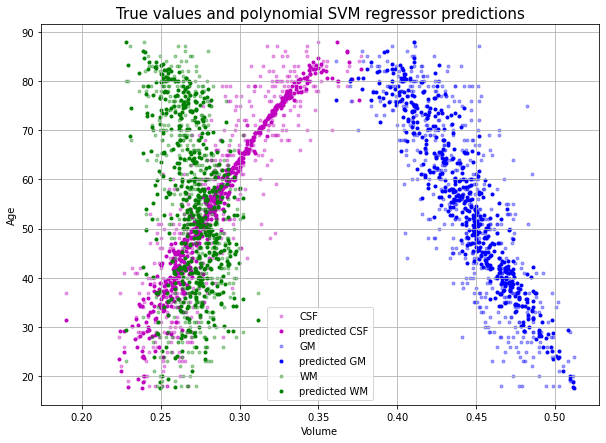

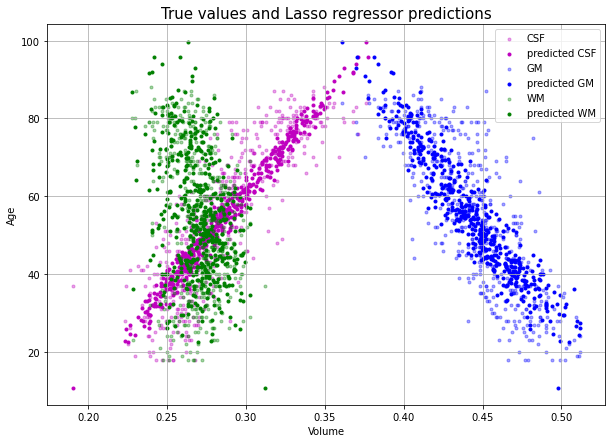

In [20]:
# Plot mean absolute error for each nodel

# create lists of errors to plot
# minus sign bc we have computed -(L1-error)
l1_err = [ -knn_MAE, -svr_MAE, -lasso_MAE]
r2_scores = [knn_r2, svr_r2, lasso_r2]


# Plotting mean abs error and r2 score
f, axes = plt.subplots(1, 2, sharey=False, figsize=(12,6))
axes[0].scatter(range(3), l1_err, s=100)
axes[0].set_title('Mean abs error')
axes[1].scatter(range(3), r2_scores, s=100, c='g')
axes[1].set_title('r2 score')
plt.setp(axes, xticks=range(3), xticklabels=('kNN', 'SVR', 'Lasso'))
f.suptitle('Metrics for three regression models on TRAINING set', fontsize=20)
plt.show()

print('\n'*3)

# Plot the true values superimposed on the true values, for each model
plt.figure(figsize=(10,7))
plt.scatter(vols_normalised[0,:],age, marker='.', alpha=0.35, c='m', label='CSF')
plt.scatter(vols_normalised[0,:],y_pred_knn, marker='.', c= 'm', label='predicted CSF')
plt.scatter(vols_normalised[1,:],age, marker='.', alpha=0.35, c='b', label='GM')
plt.scatter(vols_normalised[1,:],y_pred_knn, marker='.', c='b', label='predicted GM')
plt.scatter(vols_normalised[2,:],age, marker='.', alpha=0.35, c='g', label='WM')
plt.scatter(vols_normalised[2,:],y_pred_knn, marker='.', c='g', label='predicted WM')
plt.grid()
plt.title('True values and kNN regressor predictions', fontsize=15)
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(vols_normalised[0,:],age, marker='.', alpha=0.35, c='m', label='CSF')
plt.scatter(vols_normalised[0,:],y_pred_svr, marker='.', c= 'm', label='predicted CSF')
plt.scatter(vols_normalised[1,:],age, marker='.', alpha=0.35, c='b', label='GM')
plt.scatter(vols_normalised[1,:],y_pred_svr, marker='.', c='b', label='predicted GM')
plt.scatter(vols_normalised[2,:],age, marker='.', alpha=0.35, c='g', label='WM')
plt.scatter(vols_normalised[2,:],y_pred_svr, marker='.', c='g', label='predicted WM')
plt.grid()
plt.title('True values and polynomial SVM regressor predictions', fontsize=15)
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(vols_normalised[0,:],age, marker='.', alpha=0.35, c='m', label='CSF')
plt.scatter(vols_normalised[0,:],y_pred_lasso, marker='.', c= 'm', label='predicted CSF')
plt.scatter(vols_normalised[1,:],age, marker='.', alpha=0.35, c='b', label='GM')
plt.scatter(vols_normalised[1,:],y_pred_lasso, marker='.', c='b', label='predicted GM')
plt.scatter(vols_normalised[2,:],age, marker='.', alpha=0.35, c='g', label='WM')
plt.scatter(vols_normalised[2,:],y_pred_lasso, marker='.', c='g', label='predicted WM')
plt.grid()
plt.title('True values and Lasso regressor predictions', fontsize=15)
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend()
plt.show()

### Final test on hold-out data

#### Downloading data

This is only available once the final test data has been released.

In [ ]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-testdata.zip 
! unzip brainage-testdata.zip 

--2021-02-28 00:42:39--  https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-testdata.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1521 (1.5K) [application/zip]
Saving to: ‘brainage-testdata.zip’

brainage-testdata.z 100%[===================>]   1.49K  --.-KB/s    in 0s      

2021-02-28 00:42:40 (211 MB/s) - ‘brainage-testdata.zip’ saved [1521/1521]

Archive:  brainage-testdata.zip
  inflating: data/brain_age/meta/meta_data_regression_test.csv  


#### Loading and pre-processing of testing data

In [16]:
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_seg_test = list(meta_data_reg_test['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s]


#### Run final testing

In [17]:
out_dir = '/homes/yc7620/Documents/214_imaging/40_coursework/ml-imaging-cw/output' # FOR YANIEL
model_dir = '/homes/yc7620/Documents/214_imaging/40_coursework/ml-imaging-cw/output/model/' #FOR YANIEL

pred_dir_test = os.path.join(out_dir, 'pred_test')
if not os.path.exists(pred_dir_test):
    os.makedirs(pred_dir_test)


START TESTING...
+ Dice scores: [0.99117607 0.8238934  0.9132024  0.9387677 ] 

+ Volume similarity: [0.996469   0.93322515 0.9704962  0.971323  ] 



Reference segmentation


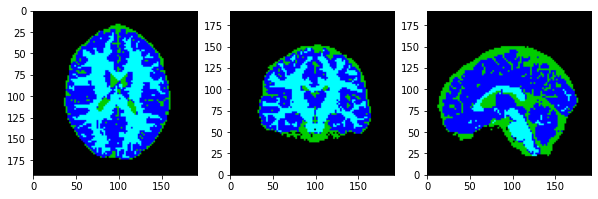

Predicted segmentation


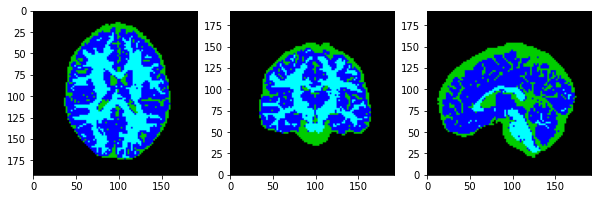


Finished TESTING.





In [22]:
# Instatiate model and load saved dictionary state
model = SimpleNet3D(num_classes=num_classes)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()

print('START TESTING...')
dices = torch.zeros(4, dtype=torch.float,device=device)
volumes = torch.zeros(4, dtype=torch.float,device=device)
sum_pts = 0
idx_test = 0
with torch.no_grad():
    for data_sample in dataloader_test:

        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        sum_pts += np.prod(img_size)
        prd = torch.argmax(prd, dim=1)
        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir_test, name))
        
        idx_test += 1

        # Dice scores
        seg = seg.squeeze(1) # To get it into shape 1x64x64x64, like prd.
        d, v = metrics(prd, seg)
        dices += d
        volumes += v

 
        
dices /= idx_test
volumes /= idx_test

print('+ Dice scores:',dices.cpu().detach().numpy(), '\n')
print('+ Volume similarity:',volumes.cpu().detach().numpy(),'\n')

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.\n\n\n')

#### Train regressors

1. We extract the volume features on our segmented test set.

2. We test our three regression models.

In [23]:
# seg_dir = '/homes/yc7620/Documents/214_imaging/40_coursework/ml-imaging-cw/output/pred_test/'
#data_dir = '/vol/bitbucket/yc7620/90_data/21_brainage_data/data/brain_age/'
meta_data = 'meta/meta_data_regression_test.csv'

# Get volume attributes and age for test each segmentation
vols_test, age = get_vols_from_images(seg_dir, data_dir, meta_data)

# Normalize volumes, reshape
vols_test_n = vols_test / vols_test.sum(axis=0)
X_test = vols_test_n.T
y_test = age.values.reshape(-1,1)

y_pred_knn_t = cross_val_predict(KNeighborsRegressor(n_neighbors=5), X_test, y_test, cv=CV_SPLIT)
y_pred_svr_t = cross_val_predict(svr.best_estimator_, X_test, y_test.reshape(100), cv=CV_SPLIT)
y_pred_lasso_t = cross_val_predict(lasso.best_estimator_, X_test, y_test.reshape(100), cv=CV_SPLIT)

Calculating Features: 100%|██████████| 100/100 [00:02<00:00, 43.05it/s]


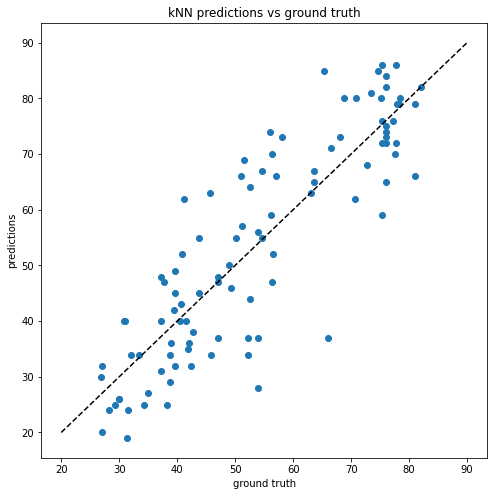

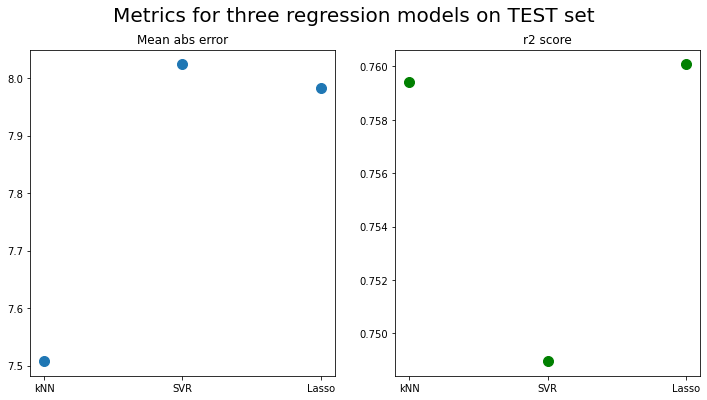

In [39]:
# Plotting ground truth vs predictions

plt.figure(figsize=(8,8))
plt.scatter(y_pred_knn_t, y_test.reshape(100))
plt.title('kNN predictions vs ground truth')
plt.xlabel('ground truth')
plt.ylabel('predictions')
plt.plot([20, 90], [20, 90], 'k--')
plt.show()


# Computing the mean absolute error

l1_err = [ mean_absolute_error(y_test.reshape(100), y_pred_knn_t),
          mean_absolute_error(y_test.reshape(100), y_pred_svr_t), 
          mean_absolute_error(y_test.reshape(100), y_pred_lasso_t)]

# Computing the r2 score
r2_scores = [ r2_score(y_test.reshape(100), y_pred_knn_t),
             r2_score(y_test.reshape(100), y_pred_svr_t), 
             r2_score(y_test.reshape(100), y_pred_lasso_t)]


# Plotting mean abs error and r2 score
f, axes = plt.subplots(1, 2, sharey=False, figsize=(12,6))
axes[0].scatter(range(3), l1_err,s=100)
axes[0].set_title('Mean abs error')
axes[1].scatter(range(3), r2_scores,s=100,c='g')
axes[1].set_title('r2 score')
plt.setp(axes, xticks=range(3), xticklabels=('kNN', 'SVR', 'Lasso'))
f.suptitle('Metrics for three regression models on TEST set', fontsize=20)
plt.show()

## Part B: Age prediction using regression CNNs

For the second approach we use a convolutional neural network to directly predict a subject's age.

We implement a CNN model that takes an MRI scan as an input and maps it to a one-dimensional, real-valued output.

In [11]:
# Dataset class
class RegressionDataset(Dataset):
    """Dataset for age regression."""

    def __init__(self, ages, file_list_img, file_list_msk, img_spacing, img_size, transform = None):
        self.samples = []
        self.img_names = []
        self.transform = transform
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            age = ages[idx]

            sample = {'age': age, 'img': img}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        age = sample['age']
        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        
        if self.transform:
            image = self.transform(image)

        return {'age': age, 'img': image}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

In [74]:
# HYPERPARAMETERS
rnd_seed = 42 #fixed random seed

img_size = [64, 64, 64]
img_spacing = [3, 3, 3]

num_epochs = 10
learning_rate = 0.001
batch_size = 2
val_interval = 2
output_channels = 8

out_dir = './ML_Imaging_output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

In [51]:
# LOADING DATA
# from torchvision import transforms
# from pytorch3d import transforms

# Train Data - 500 datapoints
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
files_reg_age_train = list(meta_data_reg_train['age'])
files_reg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_reg_train]
files_reg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_reg_train]

# Val Data - use 47 datapoints from seg_train as reg_val
meta_data_reg_val = pd.read_csv(data_dir + 'meta/meta_data_segmentation_train.csv')
ids_reg_val = list(meta_data_reg_val['subject_id'])
files_reg_age_val = list(meta_data_reg_val['age'])
files_reg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_reg_val]
files_reg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_reg_val]

data_reg_train = RegressionDataset(files_reg_age_train, files_reg_img_train, files_reg_msk_train, img_spacing, img_size)
loader_reg_train = torch.utils.data.DataLoader(data_reg_train, batch_size=batch_size, shuffle=True)

data_reg_val = RegressionDataset(files_reg_age_val, files_reg_img_val, files_reg_msk_val, img_spacing, img_size)
loader_reg_val = torch.utils.data.DataLoader(data_reg_val, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 47/47 [00:09<00:00,  5.06it/s]


In [14]:
# Loading final test data
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_reg_test = list(meta_data_reg_test['subject_id'])
files_reg_age_test = list(meta_data_reg_test['age'])
files_reg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_reg_test]
files_reg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_reg_test]

dataset_reg_test = RegressionDataset(files_reg_age_test, files_reg_img_test, files_reg_msk_test, img_spacing, img_size)
loader_reg_test = torch.utils.data.DataLoader(dataset_reg_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


In [75]:
class Regressor(nn.Module):
    
    def __init__(self):
        super(Regressor, self).__init__()
        self.layers = nn.Sequential(
            # state size 1 x 64 x 64 x 64
            nn.Conv3d(1, output_channels, 4, 2, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (output_channels) x 32 x 32 x 32
            nn.Conv3d(output_channels, output_channels * 2, 4, 2, 1, bias=True),
            nn.BatchNorm3d(output_channels * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (output_channels*2) x 16 x 16 x 16
            nn.Conv3d(output_channels * 2, output_channels * 4, 4, 2, 1, bias=True),
            nn.BatchNorm3d(output_channels * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (output_channels*4) x 8 x 8 x 8
            nn.Conv3d(output_channels * 4, output_channels * 8, 4, 2, 1, bias=True),
            nn.BatchNorm3d(output_channels * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (output_channels*8) x 4 x 4 x 4
            nn.Conv3d(output_channels * 8, 1, 4, 1, 0, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size 1 x 1 x 1 x 1
        )

    def forward(self, x):
        x = self.layers(x).view(-1)
        return x # age

In [76]:
# Train function that takes in train and test sets
def train(train_dataset, test_dataset, printer = True):
    model_img = Regressor().to(device)
    model_img.train()

    MSE_loss = nn.MSELoss(reduction = 'sum')
        
    optimizer_i = torch.optim.Adam(model_img.parameters(), lr=learning_rate)

    # Containers to collect training/validation results
    loss_train_log_i = []
    loss_val_log_i = []

    epoch_val_log = []

    print('START TRAINING...')
    for epoch in range(1, num_epochs + 1):
        loss_train_i = 0
        train_pts = 0
        
        # Training
        for batch_idx, samples in enumerate(train_dataset):
            age, img = samples['age'].to(device), samples['img'].to(device)
            optimizer_i.zero_grad()
            prd_i = model_img(img.float())
            loss_i = MSE_loss(prd_i, age.float())

            loss_i.backward()
            optimizer_i.step()

            with torch.no_grad():
                loss_train_i += torch.sqrt(loss_i).item()
            train_pts += age.shape[0]
        
        loss_train_i /= train_pts
        loss_train_log_i.append(loss_train_i)

        if printer:
            print('+ TRAINING \tEpoch: {} \tLoss: I: {:.6f}'.format(epoch, loss_train_i))
        
        # Validation
        if epoch == 1 or epoch % val_interval == 0:
            loss_val_i = 0
            sum_pts = 0
            with torch.no_grad():
                for sample in test_dataset:
                    age, img = sample['age'].to(device), sample['img'].to(device)
                    prd_i = model_img(img.float())
                    loss_val_i += torch.sqrt(MSE_loss(prd_i, age.float())).item()
                    sum_pts += age.shape[0]

            loss_val_i /= sum_pts
            loss_val_log_i.append(loss_val_i)
            epoch_val_log.append(epoch)

            if printer:
                print('+ VALIDATE \tEpoch: {} \tLoss: I {:.6f}'.format(epoch, loss_val_i))

    print('\nFinished TRAINING.')

    # Plot graphs
    plt.plot(range(1, num_epochs + 1), loss_train_log_i, label='train')
    plt.plot(epoch_val_log, loss_val_log_i, label='val I')
    plt.legend(loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

    return model_img

In [77]:
# Test function, takes in test dataset

def test(dataset, model, plot=False):
    model.to(device)
    model.eval()

    L1_loss = nn.L1Loss(reduction = 'sum')

    print('START TESTING...')
    predictions = []
    truth = []
    loss_test = 0
    idx_test = 0
    with torch.no_grad():
        for sample in dataset:
            age, img = sample['age'].to(device), sample['img'].to(device)
            prd_i = model(img.float())
            loss_test += L1_loss(prd_i, age.float()).item()

            idx_test += age.shape[0]
            predictions.append(prd_i.tolist())
            truth.append(age.tolist())
    
    loss_test /= idx_test
    print('+ TESTING \tLoss: {:.6f}'.format(loss_test))

    truth = [item for sublist in truth for item in sublist]
    predictions = [item for sublist in predictions for item in sublist]
    if plot:
        plt.figure(figsize=(8,8))
        plt.scatter(truth, predictions)
        plt.title('Predictions vs Ground Truth')
        plt.xlabel('Ground Truth')
        plt.ylabel('Predictions')
        plt.xlim(20,95)
        plt.ylim(20,95)
        plt.show()

    print('\nFinished TESTING.')
    return truth, predictions

START TRAINING...

Finished TRAINING.


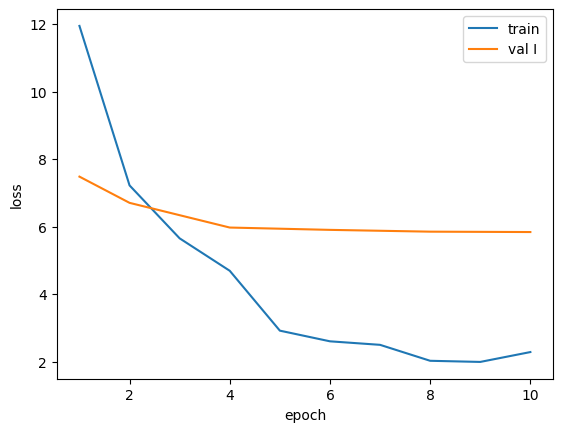

START TESTING...
+ TESTING 	Loss: 7.551510

Finished TESTING.
START TRAINING...

Finished TRAINING.


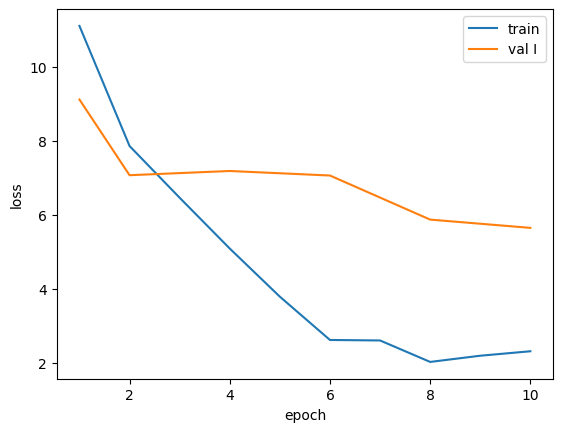

START TESTING...
+ TESTING 	Loss: 7.337998

Finished TESTING.


In [78]:
# 2-fold Cross-validation on 500 training datapoints

# Split into 2 sets for 2-fold cross-validation
set1, set2 = torch.utils.data.random_split(data_reg_train, [250, 250], generator=torch.Generator().manual_seed(42))
loader1 = torch.utils.data.DataLoader(set1, batch_size=batch_size, shuffle=True)
loader2 = torch.utils.data.DataLoader(set2, batch_size=batch_size, shuffle=True)

# Train on 1st set, test on 2nd set:
model1 = train(loader1, loader2, printer = False)
cv1_truth, cv1_pred = test(loader2, model1, False)
# Train on 2nd set, test on 1st set:
model2 = train(loader2, loader1, printer = False)
cv2_truth, cv2_pred = test(loader1, model2, False)

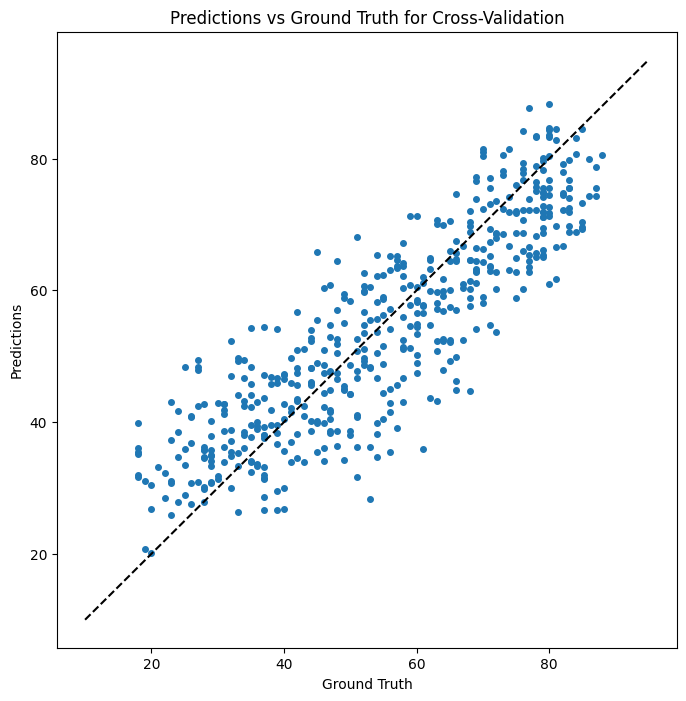

In [79]:
# Plot predictions vs truth during cross-validation
cv_truth = cv1_truth + cv2_truth
cv_pred= cv1_pred + cv2_pred

plt.style.use('default')
plt.figure(figsize=(8,8))
plt.scatter(cv_truth, cv_pred, s=16)
plt.title('Predictions vs Ground Truth for Cross-Validation')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.plot([10, 95], [10, 95], 'k--')
plt.show()

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: I: 10.012880
+ VALIDATE 	Epoch: 1 	Loss: I 8.710062
+ TRAINING 	Epoch: 2 	Loss: I: 6.368014
+ VALIDATE 	Epoch: 2 	Loss: I 8.079601
+ TRAINING 	Epoch: 3 	Loss: I: 5.216403
+ TRAINING 	Epoch: 4 	Loss: I: 3.942724
+ VALIDATE 	Epoch: 4 	Loss: I 7.538278
+ TRAINING 	Epoch: 5 	Loss: I: 3.429114
+ TRAINING 	Epoch: 6 	Loss: I: 2.641803
+ VALIDATE 	Epoch: 6 	Loss: I 7.460539
+ TRAINING 	Epoch: 7 	Loss: I: 2.131511
+ TRAINING 	Epoch: 8 	Loss: I: 1.798316
+ VALIDATE 	Epoch: 8 	Loss: I 6.972926
+ TRAINING 	Epoch: 9 	Loss: I: 1.996359
+ TRAINING 	Epoch: 10 	Loss: I: 1.932825
+ VALIDATE 	Epoch: 10 	Loss: I 6.952318

Finished TRAINING.


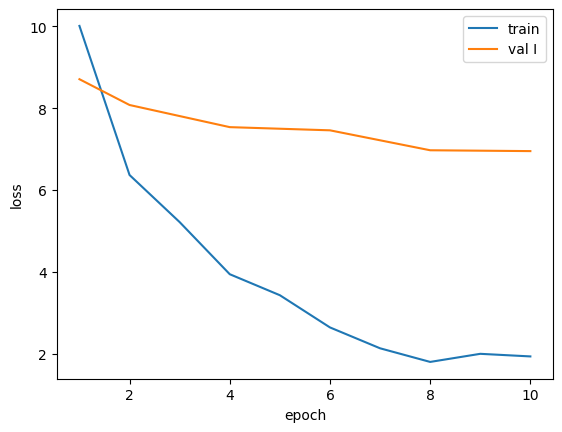

In [80]:
# Training model on 500 datapoints

model_reg = train(loader_reg_train, loader_reg_val)
torch.save(model_reg.state_dict(), os.path.join(model_dir, 'model_reg.pt'))

START TESTING...
+ TESTING 	Loss: 7.405063


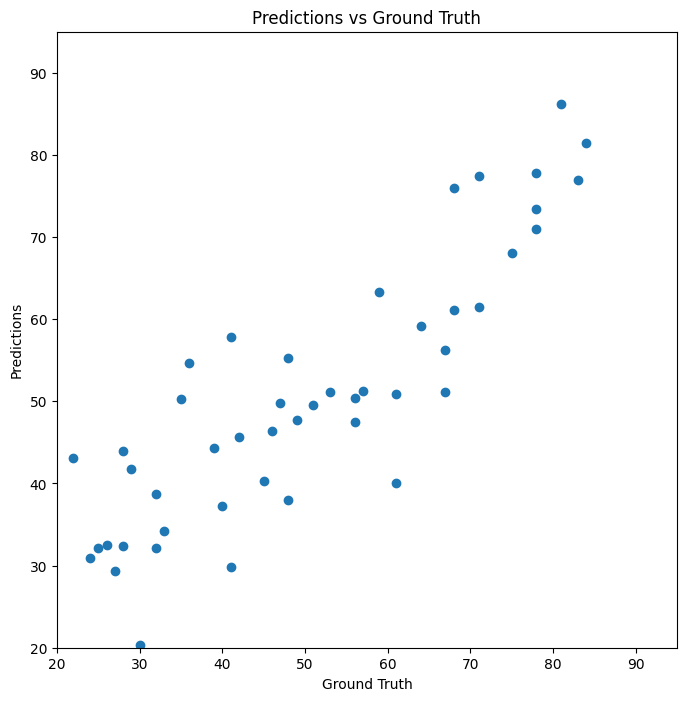


Finished TESTING.


In [81]:
# Test on 47 validation points

val_truth, val_predictions = test(loader_reg_val, model_reg, True)

START TESTING...
+ TESTING 	Loss: 7.039795


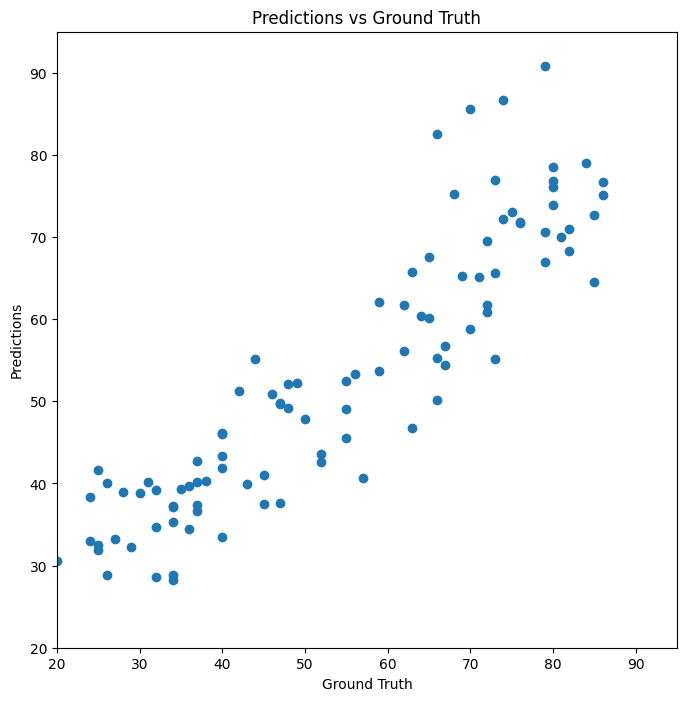


Finished TESTING.


In [82]:
# Final test on 100 test points

test_truth, test_predictions = test(loader_reg_test, model_reg, True)

START TESTING...
+ TESTING 	Loss: 2.257866

Finished TESTING.


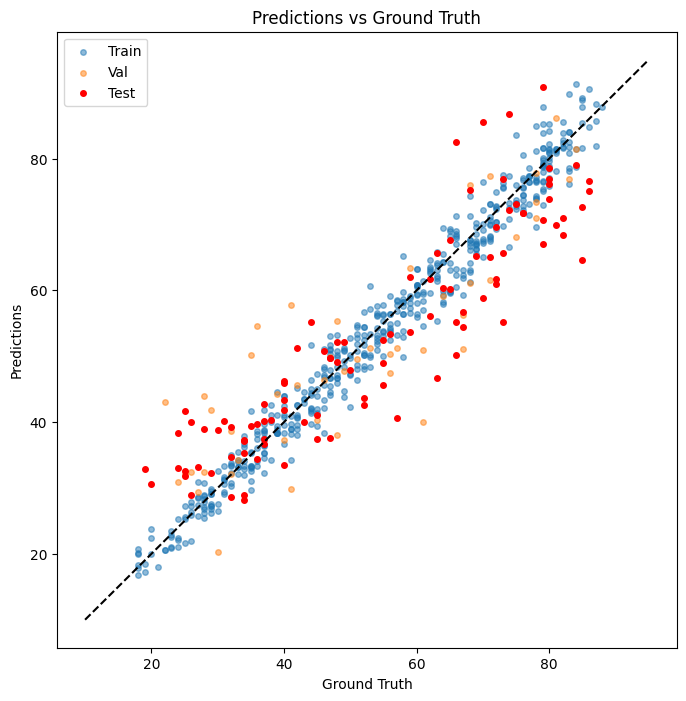

In [83]:
# Combining plots
train_truth, train_predictions = test(loader_reg_train, model_reg, False)

plt.style.use('default')
plt.figure(figsize=(8,8))
plt.scatter(train_truth, train_predictions, s=16, alpha = 0.5, label='Train')
plt.scatter(val_truth, val_predictions, s=16, alpha = 0.5, label='Val' )
plt.scatter(test_truth, test_predictions, c='red', s=16, label='Test')
plt.plot([10, 95], [10, 95], 'k--')
plt.title('Predictions vs Ground Truth')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.legend()
plt.show()

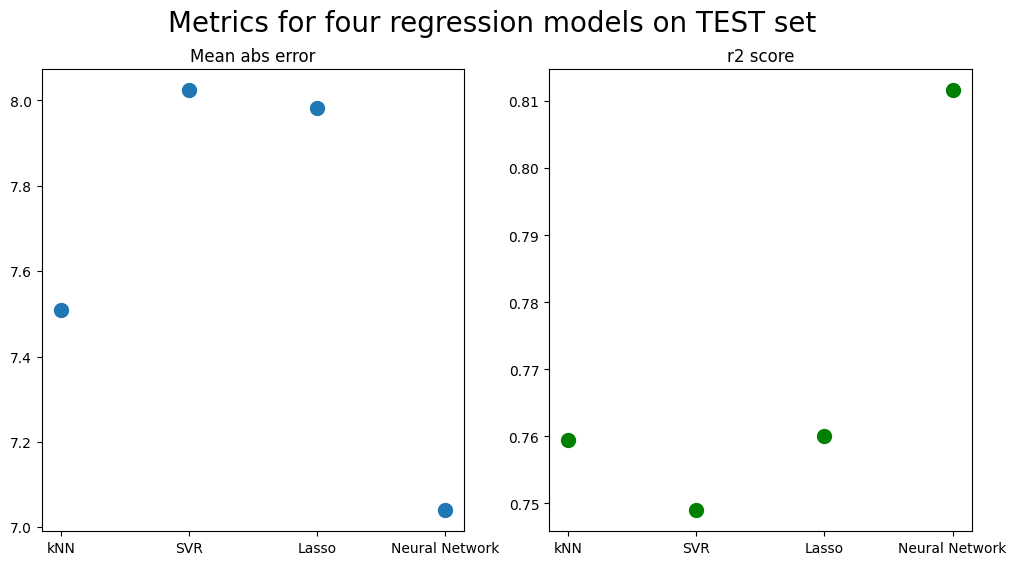

In [119]:
# Computing the mean absolute error
l1_err = [ mean_absolute_error(y_test.reshape(100), y_pred_knn_t),
          mean_absolute_error(y_test.reshape(100), y_pred_svr_t), 
          mean_absolute_error(y_test.reshape(100), y_pred_lasso_t),
          mean_absolute_error(test_truth, test_predictions)]

# Computing the r2 score
r2_scores = [ r2_score(y_test.reshape(100), y_pred_knn_t),
             r2_score(y_test.reshape(100), y_pred_svr_t), 
             r2_score(y_test.reshape(100), y_pred_lasso_t),
             r2_score(test_truth, test_predictions)]

# Plotting mean abs error and r2 score
f, axes = plt.subplots(1, 2, sharey=False, figsize=(12,6))
axes[0].scatter(range(4), l1_err,s=100)
axes[0].set_title('Mean abs error')
axes[1].scatter(range(4), r2_scores,s=100,c='g')
axes[1].set_title('r2 score')
plt.setp(axes, xticks=range(4), xticklabels=('kNN', 'SVR', 'Lasso', 'Neural Network'))
f.suptitle('Metrics for four regression models on TEST set', fontsize=20)
plt.show()

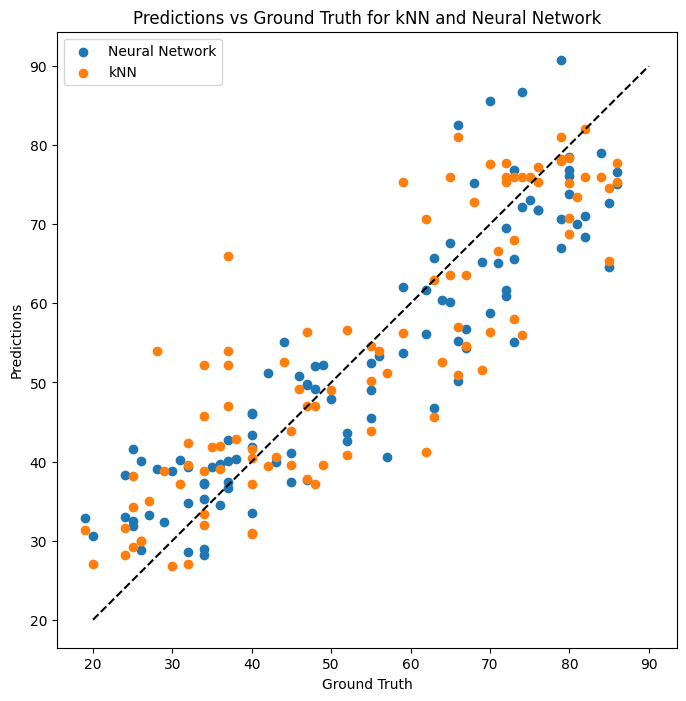

In [118]:
# Combining plots of kNN and Neural Network regressors:
plt.style.use('default')
plt.figure(figsize=(8,8))
plt.scatter(test_truth, test_predictions, label='Neural Network')
plt.scatter(y_test.reshape(100), y_pred_knn_t, label='kNN')
plt.plot([20, 90], [20, 90], 'k--')
plt.title('Predictions vs Ground Truth for kNN and Neural Network')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.legend()
plt.show()